<a href="https://colab.research.google.com/github/deltorobarba/science/blob/main/galaxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Galaxies & Nebulae**

In [ ]:
!pip install astropy astroquery reproject lightkurve -q
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import coordinates
from astroquery.ipac.irsa import Irsa
from astroquery.simbad import Simbad
from astroquery.ned import Ned
from astroquery.sdss import SDSS
from reproject import reproject_interp
from astropy.visualization import make_lupton_rgb
from astropy.visualization import astropy_mpl_style
from astroquery.mast import Observations
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import astropy_mpl_style
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
# Define Object (Galaxy)

#object_name = 'M 104'   # Sombrero Galaxy
object_name = 'M 51'    # Whirlpool Galaxy
#object_name = 'Messier 101'

In [ ]:
# Get skycoordinates of desired object
galaxy = Simbad.query_object(object_name)
ra_hms = galaxy['ra'][0]
dec_dms = galaxy['dec'][0]
print(galaxy)
print("\n")
print("-"*60)
print("RA (h:m:s):", ra_hms)
print("DEC (d:m:s):", dec_dms)

main_id     ra            dec        ...     coo_bibcode     matched_id
           deg            deg        ...                               
------- ---------- ----------------- ... ------------------- ----------
  M  51 202.469575 47.19525833333333 ... 2006AJ....131.1163S      M  51


------------------------------------------------------------
RA (h:m:s): 202.469575
DEC (d:m:s): 47.19525833333333


In [ ]:
# Set Coordinates: When Simbad data (RA and DEC columns) are in sexagesimal/hour-angle format:
# coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
# Set Coordinates: When Simbad data (RA and DEC columns) are in degrees (deg) format:
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit='deg', frame='icrs')

In [ ]:
# IRSA data
 # FITS infrared images. How many science picture are therein spitzer_images?
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip')
science_images_count = len(spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'])
print("Number of science images:", science_images_count)

Number of science images: 24


In [ ]:
# Query IRSA database
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip')

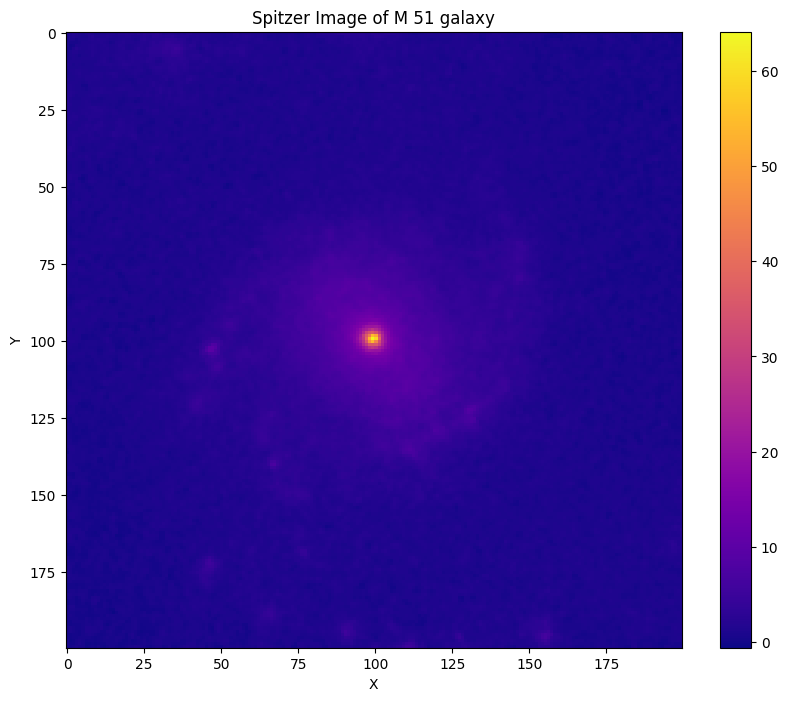

In [ ]:
# Open a cutout image for one of the science images (Filter for science images only)
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][5]  # --> number 4 or else
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].data, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8))
plt.imshow(cutout.data, cmap='plasma')
plt.colorbar()
plt.title(f'Spitzer Image of {object_name} galaxy')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# Check SDSS data availability for region
sdss_table = SDSS.query_region(coord, radius=2*u.arcmin) # broaden radius to 2 arcmin to ensure the image field is captured
print(sdss_table)

       ra              dec               objid        run  rerun camcol field
---------------- ---------------- ------------------- ---- ----- ------ -----
202.423565762729 47.1979135351773 1237661362908561423 3699   301      6   100
202.423570475396 47.1979195927486 1237661362908561450 3699   301      6   100
202.480544159544 47.1679843989206 1237661362908561426 3699   301      6   100
202.480590655247 47.1680197298315 1237661362908561456 3699   301      6   100
202.461073278613  47.227999712693 1237661362908561494 3699   301      6   100
202.441757443327 47.1799740591076 1237661362908561434 3699   301      6   100
202.441759712355 47.1799738120971 1237661362908561447 3699   301      6   100
202.441755976299 47.1799748684403 1237661362908561448 3699   301      6   100
202.460860923008 47.2123789188673 1237661362908561437 3699   301      6   100
 202.46070077128 47.2124254009397 1237661362908561478 3699   301      6   100
             ...              ...                 ...  ...   ...

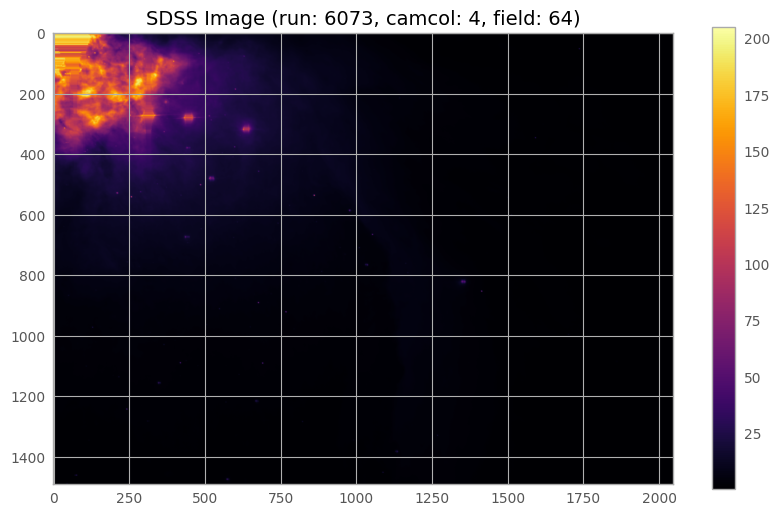

In [ ]:
# Define SDSS parameters from previous table print
plt.style.use(astropy_mpl_style)

run = 6073
rerun = 301
camcol = 4
field = 64

# Query the image using the specific SDSS parameters
try:
    # Adjust the filter band (e.g., 'r', 'g', 'i', 'z') to see how the object appears in different wavelengths
    images = SDSS.get_images(run=run, rerun=rerun, camcol=camcol, field=field, band='g')

    # Display the first image result
    for image in images:
        plt.figure(figsize=(10, 10)) # Main plot size
        plt.imshow(image[0].data, cmap='inferno') # Display the image data
        cbar = plt.colorbar(shrink=0.6) # Shrink to make colorbar vertically smaller
        cbar.ax.tick_params(labelsize=10) # Font size of colorbar ticks
        plt.title(f'SDSS Image (run: {run}, camcol: {camcol}, field: {field})', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=10) # Axis labels and ticks
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
###############################################
# Create for Multi-Wavelength Composite (with MAST)
###############################################

# Function to create composite image
def process_hst_images(params):
    # Search for observations
    obs_table = Observations.query_region(params.coords, radius=params.search_radius)

    # Filter for HST observations with specific filters
    hst_obs = obs_table[obs_table['instrument_name'] == params.instrument]

    # Get observations for each filter
    filter_data = {}
    for color, filter_name in params.rgb_filters.items():
        filter_data[color] = hst_obs[hst_obs['filters'] == filter_name]
        print(f"{filter_name}: {len(filter_data[color])} observations")

    # Check if we have all required filters
    if all(len(data) > 0 for data in filter_data.values()):

        # Download and process each filter
        hdus = {}
        for color, observations in filter_data.items():
            products = Observations.get_product_list(observations[0]['obsid'])
            files = Observations.download_products(products[products['productSubGroupDescription'] == 'DRZ'])
            hdus[color] = fits.open(files['Local Path'][0])[1]

        # Reproject images to match the red channel (Aligning images)
        aligned_data = {
            'red': hdus['red'].data,
            'green': reproject_interp(hdus['green'], hdus['red'].header)[0],
            'blue': reproject_interp(hdus['blue'], hdus['red'].header)[0]}

        # Normalize the data
        normalized_data = {color: normalize(data) for color, data in aligned_data.items()}

        # Create RGB image
        rgb = make_lupton_rgb(
            normalized_data['red'],
            normalized_data['green'],
            normalized_data['blue'],
            Q=params.rgb_params['Q'],
            stretch=params.rgb_params['stretch'])

        plt.figure(figsize=params.figure_size)
        plt.imshow(rgb, origin='lower')
        plt.title(f'{params.object_name} - HST {params.instrument} Composite')
        plt.axis('off')
        plt.show()
    else:
        print("Could not find all required filter observations")

def normalize(arr): # Normalize array data
    arr = np.nan_to_num(arr, 0)  # Replace NaN with 0
    return arr / np.percentile(arr[arr > 0], 99)

# Filter combinations for Object (HST observations)
# coords = coord # SkyCoord('13h29m52.7s +47d11m43s', unit=(u.hourangle, u.deg)) # e.g. for M51
obs_table = Observations.query_region(coord, radius=0.2 * u.deg) # Search for observations

# Get unique combinations of instruments and filters
hst_obs = obs_table[obs_table['obs_collection'] == 'HST']
unique_filters = {}

for obs in hst_obs:
    instrument = obs['instrument_name']
    filt = obs['filters']
    if instrument not in unique_filters:
        unique_filters[instrument] = set()
    if filt:  # Some observations might not have filter info
        unique_filters[instrument].add(filt)

# Print available filters by instrument
for instrument, filters in unique_filters.items():
    print(f"\n{instrument} filters:")
    for f in sorted(filters):
        print(f"  - {f}")


ACS/WFC filters:
  - F330W
  - F435W
  - F502N
  - F555W
  - F606W
  - F658N
  - F660N
  - F775W
  - F814W
  - detection

WFPC2/PC filters:
  - F160BW
  - F218W
  - F255W
  - F300W
  - F336W
  - F439W
  - F450W
  - F502N
  - F547M
  - F555W
  - F606W
  - F656N
  - F675W
  - F814W
  - detection

WFC3/IR filters:
  - BLANK
  - F105W
  - F110W
  - F125W
  - F128N
  - F140W
  - F153M
  - F160W
  - detection

WFC3/UVIS filters:
  - F225W
  - F275W
  - F280N
  - F336W
  - F343N
  - F373N
  - F390M
  - F438W
  - F467M
  - F475W
  - F475X
  - F487N
  - F502N
  - F547M
  - F555W
  - F606W
  - F631N
  - F657N
  - F673N
  - F689M
  - F814W
  - F845M
  - detection

ACS/HRC filters:
  - F220W
  - F250W
  - F330W
  - F555W
  - F775W
  - F814W
  - PR200L
  - detection

STIS filters:
  - G230L
  - G430L
  - G430L;G430M;G750L
  - G430L;G430M;G750L;G750M
  - G430L;G750M
  - G750M

NICMOS/NIC2 filters:
  - BLANK
  - F110W
  - F160W
  - F187N
  - F190N
  - F205W
  - F212N
  - F215N
  - F216N
  - F222M

N

F275W: 36 observations
F606W: 77 observations
F814W: 15 observations


/usr/local/lib/python3.12/dist-packages/astropy/visualization/lupton_rgb.py:645: RuntimeWarning: invalid value encountered in divide
  fInorm = np.where(Int <= 0, 0, np.true_divide(fI, Int))


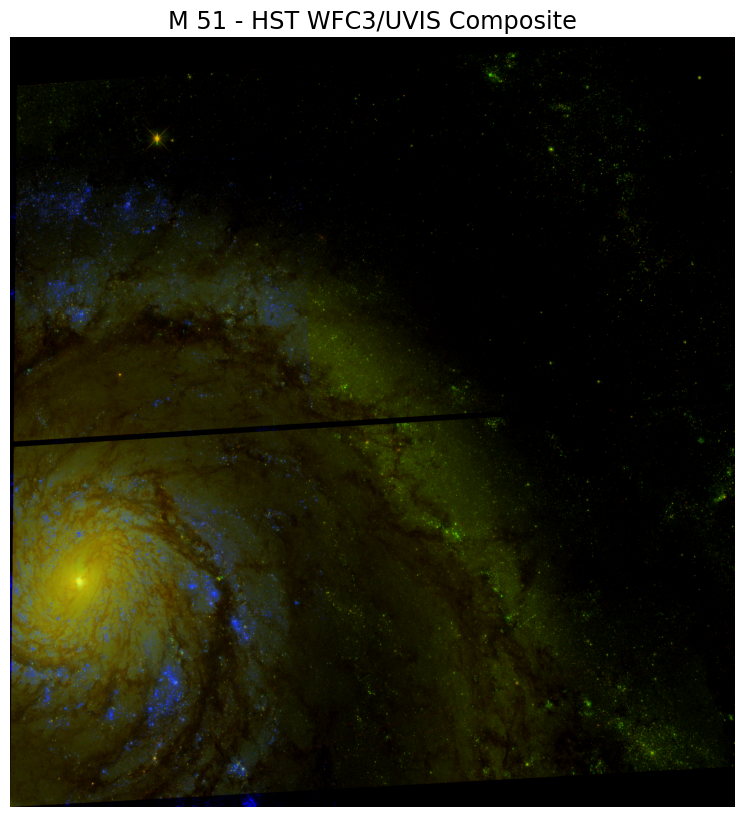

In [ ]:
# Create composite image for Whirpool Galaxy
class ObservationParams:
    def __init__(self):
        self.coords = coord # Target coordinates
        self.search_radius = 0.2 * u.deg

        self.rgb_filters = {'blue': 'F275W', 'green': 'F606W', 'red': 'F814W'}
        self.instrument = 'WFC3/UVIS'

        #self.rgb_filters = {'blue': 'F435W', 'green': 'F555W', 'red': 'F814W'}
        #self.instrument = 'ACS/WFC'

        self.rgb_params = {'Q': 10, 'stretch': 0.5} # Image processing parameters
        self.figure_size = (10, 10) # Visualization parameters
        self.object_name = object_name

params = ObservationParams()
process_hst_images(params)